# PyTorch Workflow

One of the workflows when using PyTorch for doing ML is as follows:  
- → preprocessing raw data  
- → Dataset class 
- → DataLoader
- → Model (nn.Module)
- → Loss function
- → Optimizer
- → Training loop
- → Validation loop
- → Metrics + plots
- → Physical interpretation


## 1. Data Processing (and Loading)

To start up with this, we jump into a linear regression model, with **known** parameters

In [47]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# start with known params
weight = 0.7    
bias = 0.3

start, stop, step = 0, 1, 0.02
X = torch.arange(start, stop, step).unsqueeze(dim=1) 
# what unsqueeze does is that it changes it from a 1D 
# vector along the row to a sort of Nx1 matrix for easy multiplication

y = weight * X + bias # This creates our datasets of sort

### Splitting data into training and test sets

The split is as follows: 
| Split | Yeh kya hai | %age |
|-------|-------------|------|
|Training Set|Used for training the model, sort of like course material|60-80%|
|Validation Set|Model gets tuned to this data, sort of like the practice exams|10-20%|
|Test Set|Model is finally tested on this data, like the exams given to us|10-20%|

In [49]:
# Now for the splitting
train_num = int(0.8 * len(X))
X_train, y_train = X[:train_num], y[:train_num]
X_test, y_test = X[train_num:], y[train_num:]

# And now for the visualization
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size":14})

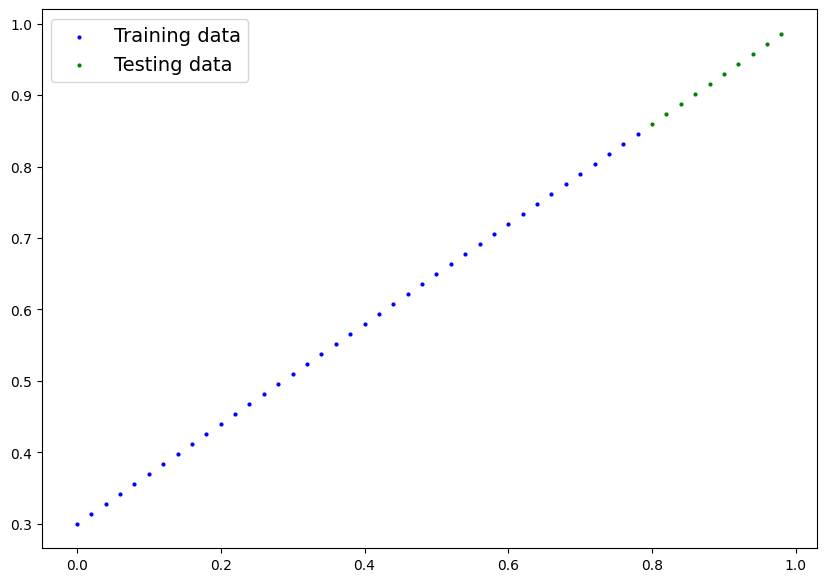

In [50]:
plot_predictions()

## 2. Building a PyTorch Model
We do end up using Python classes for this, so if required, go look it up.

In [51]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.randn(1,                      # starting with randomly assigned weight
                                                      requires_grad=True,     # using gradient descent to work out the weight
                                                      dtype=torch.float))
        self.bias = torch.nn.Parameter(torch.randn(1, 
                                                   requires_grad=True, 
                                                   dtype=torch.float))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

**Note**  
all `nn.Module` subclasses requires you to overwrite `def forward()`. This method defines what happens in the forward computation  
  
There are also 2 useful tools that will come in handy later for more important goals:  
- `torch.utils.data.Dataset`
- `torch.utils.data.DataLoader`  


In [52]:
# Assigning the model class to a variable
model_0 = LinearRegressionModel()

list(model_0.parameters()) # Returns the random initialized parameters

[Parameter containing:
 tensor([0.3962], requires_grad=True),
 Parameter containing:
 tensor([0.1057], requires_grad=True)]

#### Making Predictions using `torch.inference_mode()`

`torch.inference_mode()` is important because it doesn't store the gradient data and turns off a lot of things which are important during training but useless during inference and are otherwise carried by the parameters. This makes the code much faster especially when there are 1000's of parameters to adjust.

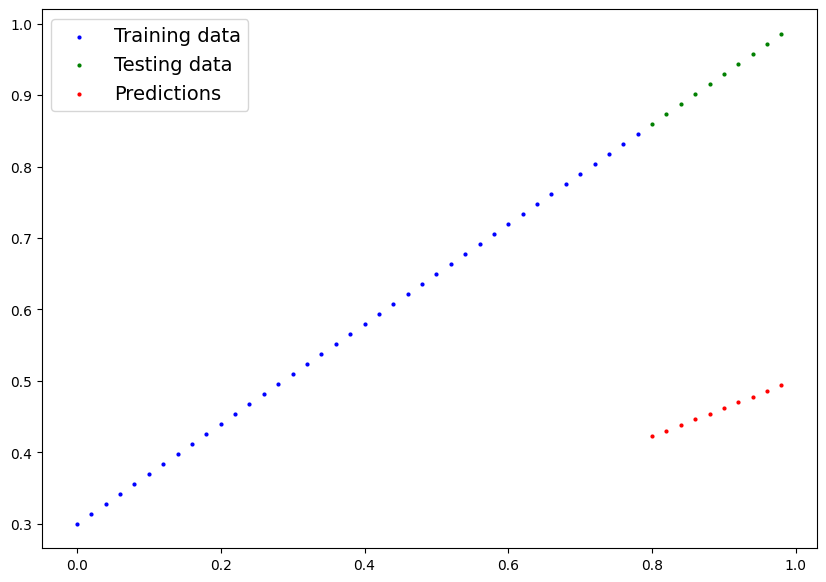

In [53]:
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

## 3. Training  
As usual best way to do it is dynamically  

### Using Loss Functions and Optimizers
| Function | Where it lives? | Common types |
|----------|-----------------|--------------|
|Loss Function|in `torch.nn`|Mean Absolute Error: `torch.nn.L1Loss()` (Regression models) <br> Binary Cross Entropy: `torch.nn.BCELoss()` (Classification models)|
|Optimizer|in `torch.optim`|Stochastic Gradient Descent: `torch.optim.SGD()` <br> Adam optimizer: `torch.optim.Adam()`|  
  
For our case, let's use MAE and SGD as lf and optims accordingly  
`torch.optim.SGD(params, lr)` is what we use for SGD where:  
- params are our parameters say weights and bias
- lr is the learning rate -> hyperparameter which we have to set ourself (typically 0.0001, 0.001, 0.01)

In [54]:
# Setting up the Loss function
loss_fn = torch.nn.L1Loss() # Mean Absolute Error

# Setting up the Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.001) # Stochastic Gradient Descent

### Procedure to follow during training
0. Loop through the data (WHY?)
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward - *back propagation algorithm*
5. Optimizer step - Now use optimizer to adjust the model's parameters to minimize loss

In [61]:
epochs = 1000 # Number of loops through the data (hyperparameter)

# 0.
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Sets all the parameters that require gradients to require gradients

    # 1. Forward pass
    y_preds = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)

    # 3. Zero the gradients
    optimizer.zero_grad() # Prevents the accumulation of gradients from previous step 5s

    # 4. Backward propagation on the loss with respect to the parameters of the model
    loss.backward() 

    # 5. Step the optimizer (update the parameters)
    optimizer.step()

    model_0.eval()

    # Testing mode
    with torch.inference_mode():

        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # --- IGNORE ---    # Print out the loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.0095 | Test Loss: 0.022182036191225052
Epoch: 10 | Loss: 0.0092 | Test Loss: 0.02135467529296875
Epoch: 20 | Loss: 0.0088 | Test Loss: 0.020595962181687355
Epoch: 30 | Loss: 0.0085 | Test Loss: 0.019768590107560158
Epoch: 40 | Loss: 0.0081 | Test Loss: 0.01894121803343296
Epoch: 50 | Loss: 0.0078 | Test Loss: 0.01818251609802246
Epoch: 60 | Loss: 0.0075 | Test Loss: 0.01735515519976616
Epoch: 70 | Loss: 0.0071 | Test Loss: 0.016527783125638962
Epoch: 80 | Loss: 0.0068 | Test Loss: 0.01576908305287361
Epoch: 90 | Loss: 0.0064 | Test Loss: 0.01494169794023037
Epoch: 100 | Loss: 0.0061 | Test Loss: 0.014182990416884422
Epoch: 110 | Loss: 0.0057 | Test Loss: 0.013355630449950695
Epoch: 120 | Loss: 0.0054 | Test Loss: 0.01252826489508152
Epoch: 130 | Loss: 0.0051 | Test Loss: 0.01176956295967102
Epoch: 140 | Loss: 0.0047 | Test Loss: 0.010942178778350353
Epoch: 150 | Loss: 0.0044 | Test Loss: 0.010114818811416626
Epoch: 160 | Loss: 0.0040 | Test Loss: 0.009356105700135231

In [64]:
print(list(model_0.parameters()))

with torch.inference_mode():
    y_preds_new = model_0(X_test)

[Parameter containing:
tensor([0.6996], requires_grad=True), Parameter containing:
tensor([0.3006], requires_grad=True)]


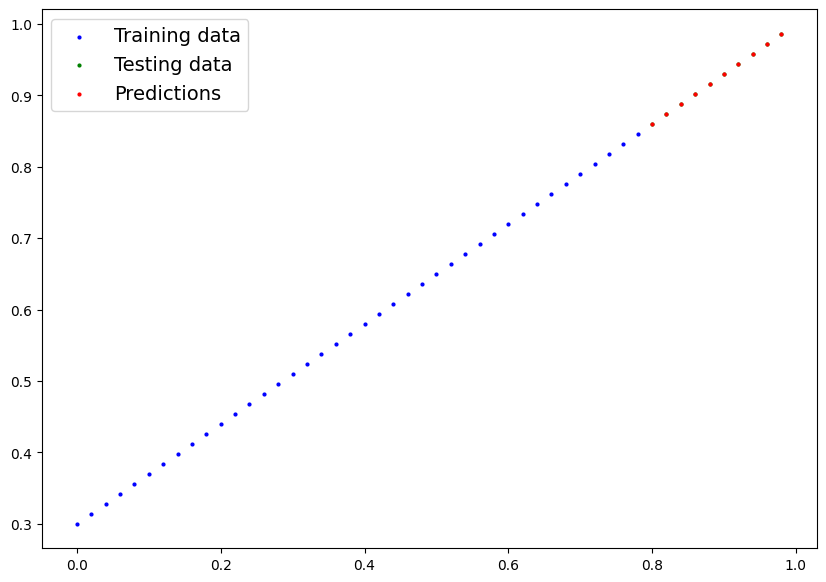

In [65]:
plot_predictions(predictions=y_preds_new)